In [ ]:
!pip install torch torchvision
!pip install ultralytics
!pip install diffusers
!pip install datasets
!pip install pillow

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from diffusers import (
    ControlNetModel,
    DDPMScheduler,
    UNet2DConditionModel,
    AutoencoderKL
)
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import numpy as np
import cv2
import os
import torch.cuda
from tqdm import tqdm
import logging
import json
from datetime import datetime
from ultralytics import YOLO
from torchvision import transforms
from torchvision.models import vgg19

In [ ]:
class KnollingDataset(Dataset):
    def __init__(self, messy_dir, tidy_dir, tokenizer, size=512):
        self.messy_dir = messy_dir
        self.tidy_dir = tidy_dir
        self.size = size
        self.tokenizer = tokenizer

        self.messy_images = sorted([f for f in os.listdir(messy_dir) if f.endswith(('.png', '.jpg'))])
        self.tidy_images = sorted([f for f in os.listdir(tidy_dir) if f.endswith(('.png', '.jpg'))])

    def __len__(self):
        return len(self.messy_images)

    def prepare_image(self, image):
        """Convert image to model input format"""
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        image = image.resize((self.size, self.size))
        image = np.array(image).astype(np.float32) / 127.5 - 1.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        return image

    def prepare_conditioning(self, image):
        """Create edge map conditioning using Canny"""
        if isinstance(image, Image.Image):
            image = np.array(image)
        if image.shape[:2] != (self.size, self.size):
            image = cv2.resize(image, (self.size, self.size))

        edge_image = cv2.Canny(image, 100, 200)
        edge_image = edge_image.astype(np.float32) / 255.0

        edge_image = np.stack([edge_image] * 3, axis=2)

        edge_tensor = torch.from_numpy(edge_image).permute(2, 0, 1).float()
        return edge_tensor

    def __getitem__(self, idx):
        messy_path = os.path.join(self.messy_dir, self.messy_images[idx])
        tidy_path = os.path.join(self.tidy_dir, self.tidy_images[idx])

        messy_img = Image.open(messy_path).convert('RGB')
        tidy_img = Image.open(tidy_path).convert('RGB')

        messy_img = messy_img.resize((self.size, self.size))
        tidy_img = tidy_img.resize((self.size, self.size))

        conditioning = self.prepare_conditioning(tidy_img)
        tidy_tensor = self.prepare_image(tidy_img)

        prompt = "organize these objects neatly on a white background"
        prompt_ids = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids[0]

        return {
            "conditioning": conditioning,
            "target": tidy_tensor,
            "prompt_ids": prompt_ids,
            "original_messy": self.prepare_image(messy_img)
        }

In [ ]:
class KnollingControlNet:
    def __init__(self, pretrained_model_path="runwayml/stable-diffusion-v1-5"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.vae = AutoencoderKL.from_pretrained(pretrained_model_path, subfolder="vae")
        self.text_encoder = CLIPTextModel.from_pretrained(pretrained_model_path, subfolder="text_encoder")
        self.tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_path, subfolder="tokenizer")
        self.controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model_path, subfolder="unet")

        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            clip_sample=False
        )

        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)
        self.unet.requires_grad_(True)
        self.controlnet.train()

        self.to(self.device)

    def to(self, device):
        self.vae.to(device)
        self.text_encoder.to(device)
        self.controlnet.to(device)
        self.unet.to(device)
        return self

    def perceptual_loss(self, x, y):
        """Simple L1 perceptual loss over VAE features"""
        x_features = self.vae.encode(x).latent_dist.mean
        y_features = self.vae.encode(y).latent_dist.mean
        return torch.mean(torch.abs(x_features - y_features))

    def train_step(self, batch):
        try:
            conditioning = batch["conditioning"].to(self.device)
            target = batch["target"].to(self.device)
            original_messy = batch["original_messy"].to(self.device)
            prompt_ids = batch["prompt_ids"].to(self.device)

            with torch.no_grad():
                encoder_hidden_states = self.text_encoder(prompt_ids)[0]
                target_latents = self.vae.encode(target).latent_dist.sample()
                target_latents = target_latents * self.vae.config.scaling_factor

            loss_dict = {}
            noise = torch.randn_like(target_latents)
            timesteps = torch.randint(
                0, self.noise_scheduler.config.num_train_timesteps,
                (target_latents.shape[0],), device=self.device
            ).long()

            noisy_latents = self.noise_scheduler.add_noise(target_latents, noise, timesteps)
            down_block_res_samples, mid_block_res_sample = self.controlnet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=encoder_hidden_states,
                controlnet_cond=conditioning,
                return_dict=False,
            )

            noise_pred = self.unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=encoder_hidden_states,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            ).sample

            noise_loss = F.mse_loss(noise_pred, noise, reduction="mean")
            loss_dict["noise"] = noise_loss.item()
            total_loss = noise_loss

            with torch.no_grad():
                single_noise_pred = noise_pred[0:1]
                single_timestep = timesteps[0:1]
                single_noisy_latents = noisy_latents[0:1]

                pred_latents = self.noise_scheduler.step(
                    model_output=single_noise_pred,
                    timestep=single_timestep,
                    sample=single_noisy_latents
                ).prev_sample

                pred_images = self.vae.decode(pred_latents / self.vae.config.scaling_factor).sample

                messy_features = self.vae.encode(original_messy[0:1]).latent_dist.mean
                pred_features = self.vae.encode(pred_images).latent_dist.mean

                content_loss = F.mse_loss(
                    messy_features / messy_features.norm(dim=1, keepdim=True),
                    pred_features / pred_features.norm(dim=1, keepdim=True),
                    reduction="mean"
                )
                loss_dict["content"] = content_loss.item()

                total_loss = total_loss + 0.01 * content_loss
                target_features = self.vae.encode(target[0:1]).latent_dist.mean
                perceptual_loss = F.mse_loss(
                    pred_features / pred_features.norm(dim=1, keepdim=True),
                    target_features / target_features.norm(dim=1, keepdim=True),
                    reduction="mean"
                )
                loss_dict["perceptual"] = perceptual_loss.item()

                total_loss = total_loss + 0.01 * perceptual_loss

            kl_loss = torch.nn.functional.kl_div(
                F.log_softmax(noise_pred.flatten(1), dim=-1),
                F.softmax(noise.flatten(1), dim=-1),
                reduction="batchmean"
            )
            loss_dict["kl"] = kl_loss.item()
            total_loss = total_loss + 0.001 * kl_loss

            if torch.isnan(total_loss) or torch.isinf(total_loss) or total_loss > 100:
                print(f"Warning: Unstable loss detected: {total_loss}")
                return noise_loss, {"noise": noise_loss.item()}

            return total_loss, loss_dict

        except Exception as e:
            print(f"Error in train_step: {str(e)}")
            print(f"Shapes:")
            print(f"  conditioning: {conditioning.shape}")
            print(f"  target: {target.shape}")
            print(f"  original_messy: {original_messy.shape}")
            print(f"  prompt_ids: {prompt_ids.shape}")
            print(f"  noise_pred: {noise_pred.shape}")
            print(f"  timesteps: {timesteps.shape}")
            raise e

    def train(self, train_dataloader, num_epochs=100, learning_rate=1e-5):
        try:
            optimizer = optim.AdamW([
                {'params': self.controlnet.parameters(), 'lr': learning_rate, 'weight_decay': 0.01}
            ])

            num_training_steps = num_epochs * len(train_dataloader)
            num_warmup_steps = num_training_steps // 10

            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=learning_rate,
                total_steps=num_training_steps,
                pct_start=0.1,
                anneal_strategy='cos'
            )

            best_loss = float('inf')
            patience = 5
            patience_counter = 0

            for epoch in range(num_epochs):
                self.controlnet.train()
                running_loss = 0.0
                loss_components = {"noise": 0.0, "content": 0.0, "perceptual": 0.0, "kl": 0.0}
                num_batches = len(train_dataloader)

                with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
                    for step, batch in enumerate(pbar):
                        try:
                            loss, loss_dict = self.train_step(batch)

                            if torch.isnan(loss) or torch.isinf(loss) or loss > 100:
                                print(f"Skipping step {step} due to bad loss value: {loss}")
                                continue

                            optimizer.zero_grad()
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(self.controlnet.parameters(), max_norm=1.0)
                            optimizer.step()
                            scheduler.step()

                            running_loss += loss.item()
                            for k, v in loss_dict.items():
                                loss_components[k] += v

                            pbar.set_postfix({
                                'loss': f"{loss.item():.4f}",
                                'lr': f"{scheduler.get_last_lr()[0]:.2e}"
                            })

                            if step % 10 == 0:
                                print("\nLoss components:")
                                for k, v in loss_dict.items():
                                    print(f"  {k}: {v:.4f}")

                        except Exception as e:
                            print(f"\nError in batch {step}: {str(e)}")
                            continue

                avg_loss = running_loss / num_batches
                print(f"\nEpoch {epoch+1} Summary:")
                print(f"Average Loss: {avg_loss:.4f}")
                for k, v in loss_components.items():
                    print(f"Average {k} loss: {v/num_batches:.4f}")

                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0

                    save_path = f"knolling_controlnet_best"
                    os.makedirs(save_path, exist_ok=True)
                    self.controlnet.save_pretrained(save_path)

                    metrics = {
                        'epoch': epoch + 1,
                        'avg_loss': avg_loss,
                        'loss_components': {k: v/num_batches for k, v in loss_components.items()},
                        'learning_rate': scheduler.get_last_lr()[0],
                        'best_loss': True
                    }
                    with open(os.path.join(save_path, 'metrics.json'), 'w') as f:
                        json.dump(metrics, f, indent=2)
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"\nEarly stopping triggered after {epoch+1} epochs")
                        break

                if (epoch + 1) % 5 == 0:
                    save_path = f"knolling_controlnet_epoch_{epoch+1}"
                    os.makedirs(save_path, exist_ok=True)
                    self.controlnet.save_pretrained(save_path)
                    metrics = {
                        'epoch': epoch + 1,
                        'avg_loss': avg_loss,
                        'loss_components': {k: v/num_batches for k, v in loss_components.items()},
                        'learning_rate': scheduler.get_last_lr()[0]
                    }
                    with open(os.path.join(save_path, 'metrics.json'), 'w') as f:
                        json.dump(metrics, f, indent=2)

        except Exception as e:
            print(f"Training error: {str(e)}")
            raise e

    @torch.no_grad()
    def generate(self, messy_image, num_inference_steps=50, strength=0.8, display_intermediate=False):
        self.controlnet.eval()

        if isinstance(messy_image, Image.Image):
            messy_image = messy_image.resize((512, 512))
        else:
            messy_image = Image.fromarray(messy_image).resize((512, 512))

        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        messy_tensor = preprocess(messy_image).unsqueeze(0).to(self.device)

        init_latents = self.vae.encode(messy_tensor).latent_dist.sample()
        init_latents = init_latents * self.vae.config.scaling_factor

        edge_image = cv2.Canny(np.array(messy_image.convert('RGB')), 100, 200)
        edge_image = edge_image.astype(np.float32) / 255.0
        edge_image = np.stack([edge_image] * 3, axis=2)
        edge_tensor = torch.from_numpy(edge_image).permute(2, 0, 1).float()
        edge_tensor = edge_tensor.unsqueeze(0).to(self.device)

        prompt = "organize these objects neatly on a white background"
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids.to(self.device)

        encoder_hidden_states = self.text_encoder(text_input)[0]

        if strength < 0 or strength > 1:
            raise ValueError("Strength should be between 0 and 1")

        self.noise_scheduler.set_timesteps(num_inference_steps)
        init_timestep = int(num_inference_steps * strength)
        init_timestep = min(init_timestep, num_inference_steps - 1)

        timesteps = self.noise_scheduler.timesteps
        timestep = timesteps[-init_timestep]
        timestep = torch.tensor([timestep], device=self.device).long()

        noise = torch.randn_like(init_latents)
        latents = self.noise_scheduler.add_noise(init_latents, noise, timestep)
        timesteps = self.noise_scheduler.timesteps[-init_timestep:]

        progress_bar = tqdm(timesteps)
        for t in progress_bar:
            timestep = t.expand(latents.shape[0])

            down_block_res_samples, mid_block_res_sample = self.controlnet(
                latents,
                t,
                encoder_hidden_states=encoder_hidden_states,
                controlnet_cond=edge_tensor,
                return_dict=False
            )

            noise_pred = self.unet(
                latents,
                t,
                encoder_hidden_states=encoder_hidden_states,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample
            ).sample

            latents = self.noise_scheduler.step(
                model_output=noise_pred,
                timestep=t,
                sample=latents
            ).prev_sample

            if display_intermediate:
                temp_latents = latents / self.vae.config.scaling_factor
                temp_image = self.vae.decode(temp_latents).sample
                temp_image = (temp_image / 2 + 0.5).clamp(0, 1)
                temp_image = temp_image.cpu().permute(0, 2, 3, 1).float().numpy()
                temp_image = (temp_image * 255).round().astype("uint8")[0]

                intermediate_image = Image.fromarray(temp_image)
                from IPython.display import display, clear_output
                clear_output(wait=True)
                display(intermediate_image)

            progress_bar.set_description(f"Denoising: {t.item()}")

        latents = latents / self.vae.config.scaling_factor
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        image = (image * 255).round().astype("uint8")[0]

        return Image.fromarray(image)

    def __del__(self):
        if hasattr(self, 'controlnet'):
            del self.controlnet
        if hasattr(self, 'unet'):
            del self.unet
        if hasattr(self, 'vae'):
            del self.vae
        if hasattr(self, 'text_encoder'):
            del self.text_encoder
        torch.cuda.empty_cache()

In [ ]:
abs_path = '/content/drive/Othercomputers/MacBook Pro (Personal)/Documents/COLUMBIA UNIVERSITY/MSCS/Research/Knolling Bot/Preliminary Pipeline/'
messy_dir = abs_path + 'data/images_before_small/'
tidy_dir = abs_path + 'data/images_after_small/'

model = KnollingControlNet()
dataset = KnollingDataset(messy_dir, tidy_dir, model.tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
model.train(dataloader, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Epoch 1/10:   4%|▎         | 1/27 [00:02<01:09,  2.69s/it, loss=0.0140, lr=4.35e-07]


Loss components:
  noise: 0.0077
  content: 0.3254
  perceptual: 0.3087
  kl: 0.0038


Epoch 1/10:  41%|████      | 11/27 [00:13<00:20,  1.27s/it, loss=0.0178, lr=4.05e-06]


Loss components:
  noise: 0.0151
  content: 0.1788
  perceptual: 0.0837
  kl: 0.0076


Epoch 1/10:  78%|███████▊  | 21/27 [00:25<00:06,  1.09s/it, loss=0.0168, lr=9.15e-06]


Loss components:
  noise: 0.0076
  content: 0.4653
  perceptual: 0.4544
  kl: 0.0043


Epoch 1/10: 100%|██████████| 27/27 [00:30<00:00,  1.14s/it, loss=0.0175, lr=1.00e-05]



Epoch 1 Summary:
Average Loss: 0.0185
Average noise loss: 0.0135
Average content loss: 0.2744
Average perceptual loss: 0.2252
Average kl loss: 0.0071


Epoch 2/10:   4%|▎         | 1/27 [00:01<00:26,  1.04s/it, loss=0.0112, lr=1.00e-05]


Loss components:
  noise: 0.0101
  content: 0.0779
  perceptual: 0.0240
  kl: 0.0051


Epoch 2/10:  41%|████      | 11/27 [00:12<00:16,  1.02s/it, loss=0.0235, lr=9.94e-06]


Loss components:
  noise: 0.0215
  content: 0.1477
  perceptual: 0.0483
  kl: 0.0109


Epoch 2/10:  78%|███████▊  | 21/27 [00:22<00:06,  1.00s/it, loss=0.0229, lr=9.80e-06]


Loss components:
  noise: 0.0138
  content: 0.4575
  perceptual: 0.4537
  kl: 0.0070


Epoch 2/10: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it, loss=0.0100, lr=9.68e-06]



Epoch 2 Summary:
Average Loss: 0.0154
Average noise loss: 0.0108
Average content loss: 0.2588
Average perceptual loss: 0.2055
Average kl loss: 0.0055


Epoch 3/10:   4%|▎         | 1/27 [00:01<00:27,  1.04s/it, loss=0.0118, lr=9.65e-06]


Loss components:
  noise: 0.0036
  content: 0.4153
  perceptual: 0.4063
  kl: 0.0017


Epoch 3/10:  41%|████      | 11/27 [00:11<00:16,  1.02s/it, loss=0.0224, lr=9.38e-06]


Loss components:
  noise: 0.0210
  content: 0.1210
  perceptual: 0.0149
  kl: 0.0107


Epoch 3/10:  78%|███████▊  | 21/27 [00:21<00:06,  1.01s/it, loss=0.0314, lr=9.03e-06]


Loss components:
  noise: 0.0287
  content: 0.1829
  perceptual: 0.0821
  kl: 0.0152


Epoch 3/10: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it, loss=0.0108, lr=8.79e-06]



Epoch 3 Summary:
Average Loss: 0.0184
Average noise loss: 0.0143
Average content loss: 0.2378
Average perceptual loss: 0.1719
Average kl loss: 0.0074


Epoch 4/10:   4%|▎         | 1/27 [00:00<00:25,  1.01it/s, loss=0.0106, lr=8.75e-06]


Loss components:
  noise: 0.0018
  content: 0.4491
  perceptual: 0.4366
  kl: 0.0008


Epoch 4/10:  41%|████      | 11/27 [00:10<00:15,  1.00it/s, loss=0.0219, lr=8.29e-06]


Loss components:
  noise: 0.0157
  content: 0.3184
  perceptual: 0.2978
  kl: 0.0074


Epoch 4/10:  78%|███████▊  | 21/27 [00:20<00:06,  1.00s/it, loss=0.0323, lr=7.77e-06]


Loss components:
  noise: 0.0313
  content: 0.0998
  perceptual: 0.0017
  kl: 0.0162


Epoch 4/10: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, loss=0.0104, lr=7.44e-06]



Epoch 4 Summary:
Average Loss: 0.0168
Average noise loss: 0.0119
Average content loss: 0.2714
Average perceptual loss: 0.2220
Average kl loss: 0.0059


Epoch 5/10:   4%|▎         | 1/27 [00:00<00:25,  1.00it/s, loss=0.0156, lr=7.39e-06]


Loss components:
  noise: 0.0142
  content: 0.1243
  perceptual: 0.0139
  kl: 0.0071


Epoch 5/10:  41%|████      | 11/27 [00:11<00:16,  1.00s/it, loss=0.0111, lr=6.80e-06]


Loss components:
  noise: 0.0023
  content: 0.4476
  perceptual: 0.4307
  kl: 0.0011


Epoch 5/10:  78%|███████▊  | 21/27 [00:21<00:05,  1.00it/s, loss=0.0108, lr=6.18e-06]


Loss components:
  noise: 0.0022
  content: 0.4370
  perceptual: 0.4237
  kl: 0.0011


Epoch 5/10: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s, loss=0.0120, lr=5.80e-06]



Epoch 5 Summary:
Average Loss: 0.0166
Average noise loss: 0.0114
Average content loss: 0.2870
Average perceptual loss: 0.2322
Average kl loss: 0.0058


Epoch 6/10:   4%|▎         | 1/27 [00:01<00:26,  1.03s/it, loss=0.0269, lr=5.74e-06]


Loss components:
  noise: 0.0195
  content: 0.3764
  perceptual: 0.3570
  kl: 0.0104


Epoch 6/10:  41%|████      | 11/27 [00:11<00:15,  1.00it/s, loss=0.0303, lr=5.10e-06]


Loss components:
  noise: 0.0212
  content: 0.4593
  perceptual: 0.4533
  kl: 0.0113


Epoch 6/10:  78%|███████▊  | 21/27 [00:21<00:05,  1.01it/s, loss=0.0101, lr=4.45e-06]


Loss components:
  noise: 0.0085
  content: 0.1130
  perceptual: 0.0479
  kl: 0.0041


Epoch 6/10: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s, loss=0.0233, lr=4.07e-06]



Epoch 6 Summary:
Average Loss: 0.0171
Average noise loss: 0.0128
Average content loss: 0.2431
Average perceptual loss: 0.1917
Average kl loss: 0.0065


Epoch 7/10:   4%|▎         | 1/27 [00:01<00:26,  1.00s/it, loss=0.0076, lr=4.00e-06]


Loss components:
  noise: 0.0029
  content: 0.2446
  perceptual: 0.2236
  kl: 0.0015


Epoch 7/10:  41%|████      | 11/27 [00:10<00:15,  1.00it/s, loss=0.0345, lr=3.38e-06]


Loss components:
  noise: 0.0318
  content: 0.1580
  perceptual: 0.1112
  kl: 0.0168


Epoch 7/10:  78%|███████▊  | 21/27 [00:20<00:05,  1.00it/s, loss=0.0093, lr=2.78e-06]


Loss components:
  noise: 0.0045
  content: 0.2524
  perceptual: 0.2203
  kl: 0.0021


Epoch 7/10:  89%|████████▉ | 24/27 [00:23<00:03,  1.01s/it, loss=0.0153, lr=2.61e-06]

In [ ]:
messy_images = [Image.open(os.path.join(messy_dir, filename)) for filename in sorted(os.listdir(messy_dir)) if filename.endswith(('.png', '.jpg'))]
tidy_images = [Image.open(os.path.join(tidy_dir, filename)) for filename in sorted(os.listdir(tidy_dir)) if filename.endswith(('.png', '.jpg'))]

In [ ]:
tidy_result = model.generate(messy_images[100], display_intermediate=False)

Denoising: 0: 100%|██████████| 40/40 [00:04<00:00,  9.72it/s]


In [ ]:
tidy_result1 = Image.open(os.path.join(abs_path, "tidy_1.png"))

In [ ]:
tidy_result2 = Image.open(os.path.join(abs_path, "tidy_2.png"))

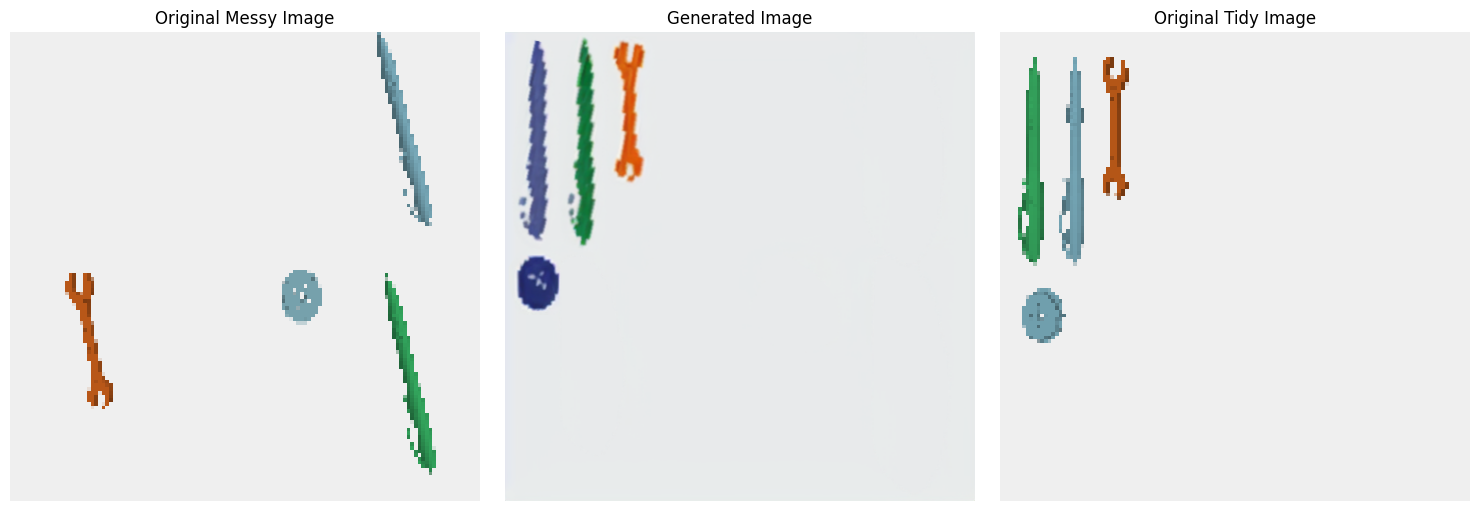

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(messy_images[1])
axes[0].set_title("Original Messy Image")
axes[0].axis('off')

axes[1].imshow(tidy_result2)
axes[1].set_title("Generated Image")
axes[1].axis('off')

axes[2].imshow(tidy_images[1])
axes[2].set_title("Original Tidy Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

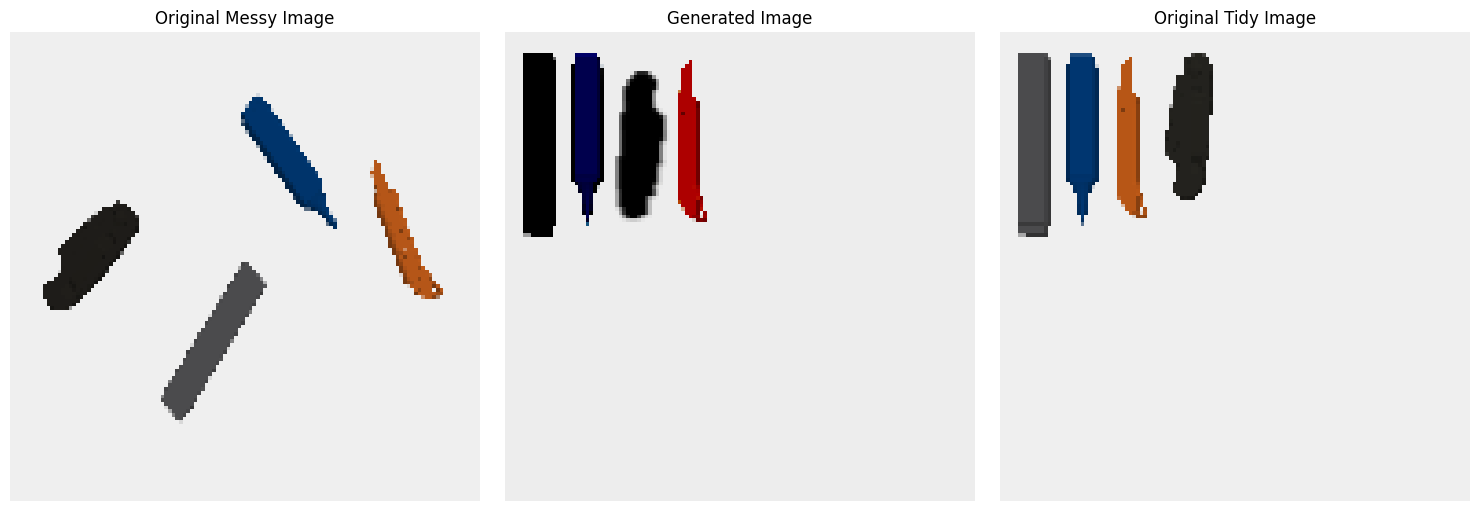

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(messy_images[100])
axes[0].set_title("Original Messy Image")
axes[0].axis('off')

axes[1].imshow(tidy_result1)
axes[1].set_title("Generated Image")
axes[1].axis('off')

axes[2].imshow(tidy_images[100])
axes[2].set_title("Original Tidy Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()